In [1]:
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
from dask.distributed import Client, progress
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
from scipy import stats
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid
# %matplotlib inline

In [2]:
def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(latitude=slice(10,50), longitude=slice(210,250))

In [3]:
filename_pattern =  '/home/sbarc/students/nash/data/CFSv2/netcdf_CFSv2/2019*'
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', preprocess=preprocess)
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
# ds.info()

ds size in GB 0.15



In [4]:
da_u = ds.UGRD_250mb.load()
da_v = ds.VGRD_250mb.load()
da_u_knots = da_u * 1.94384 ## convert to knots
da_v_knots = da_v * 1.94384 ## convert to knots
da_wind_magnitude = np.sqrt((da_u*da_u)+(da_v*da_v))
da_GPH = ds.HGT_250mb.load()

## Plot S1

./figures/fS1.png


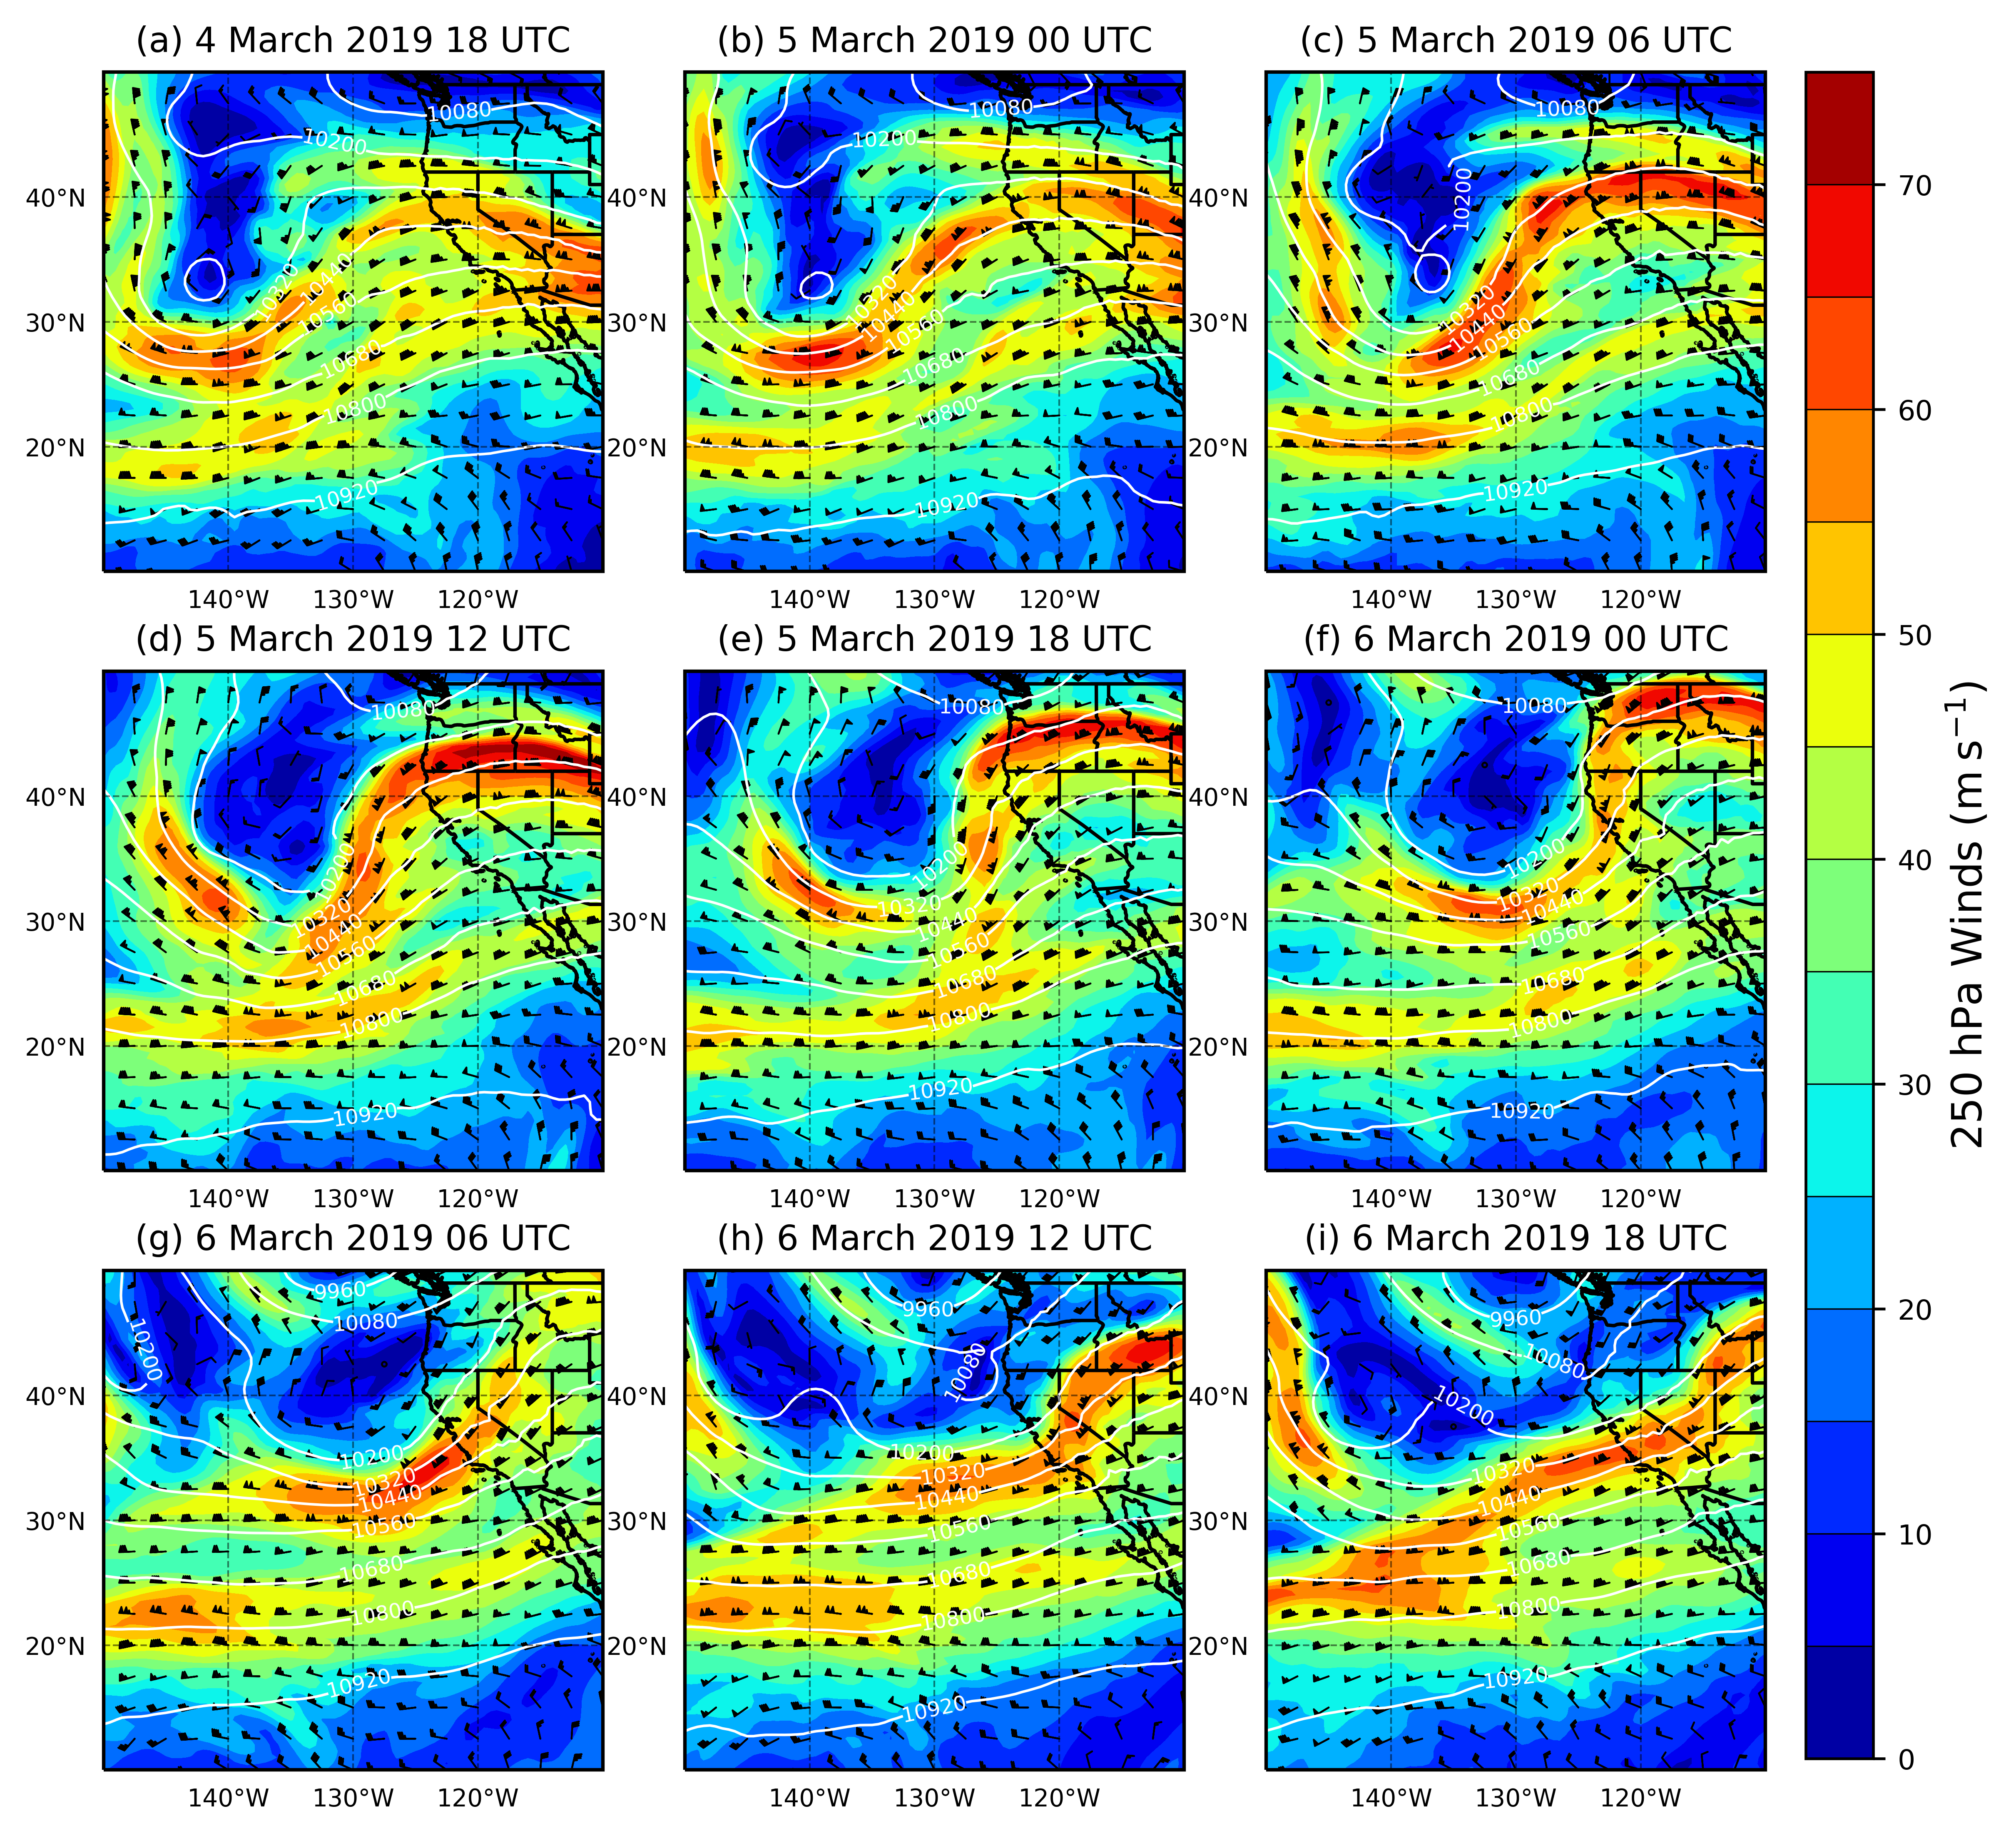

<Figure size 5400x5400 with 0 Axes>

In [7]:
fig = plt.figure(figsize=(9,9))
fig.dpi = 600
fname = './figures/fS1'
fmt1 = 'png'
fmt2 = 'pdf'
results = da_wind_magnitude
subtitles = ['(a) 4 March 2019 18 UTC', 
             '(b) 5 March 2019 00 UTC', '(c) 5 March 2019 06 UTC', '(d) 5 March 2019 12 UTC',
             '(e) 5 March 2019 18 UTC',
            '(f) 6 March 2019 00 UTC', '(g) 6 March 2019 06 UTC', '(h) 6 March 2019 12 UTC',
             '(i) 6 March 2019 18 UTC']

lats = ds['latitude']
lons = ds['longitude']
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

for i in np.arange(len(results)):
    ax = plt.subplot(3, 3, i+1, projection=mapcrs)
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=mapcrs)
    
    # Plot Wind magnitude
    clevs = np.arange(0,80,5)
    cf = ax.contourf(lons, lats, results[i], transform=datacrs,
                     extend='neither', cmap='jet', levels=clevs)
    
    # Plot Wind Barbs
    barbx = 5
    barbs = ax.barbs(lons[::barbx], lats[::barbx],
                     da_u_knots[i, ::barbx, ::barbx], da_v_knots[i, ::barbx, ::barbx],
                     length=3, linewidth=0.5)
    
    # Plot GPH
    clevsgph = np.arange(0, 11000, 120)
    kw_clabels = {'fontsize': 6, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    cs = ax.contour(lons, lats, da_GPH[i,:,:], levels=clevsgph, colors='white',
                    linewidths=0.75, linestyles='solid', transform=datacrs)
    plt.clabel(cs, **kw_clabels)
    
    # Add Border Features
    ax.coastlines(linewidths=1.0, resolution='10m')
    ax.add_feature(states_provinces, edgecolor='k')
    ax.add_feature(cfeature.BORDERS)
    
    ax.set_title(subtitles[i], fontsize=10)
    ## Add in meridian and parallels
    gl = ax.gridlines(crs=mapcrs, draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-150, -140, -130, -120, -110])
    gl.ylocator = mticker.FixedLocator([10,20, 30, 40, 50])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.9, 0.13, 0.03, 0.75])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('250 hPa Winds $\mathrm{(m \: s^{-1})}$', fontsize=12)

plt.subplots_adjust(hspace=0.2, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))